# Fit Lineages in ONS Data

© 2022 Thomas House and Roberto Cahuantzi

Code for analysis of lineage prevalences and growth rates in the ONS CIS data.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import scipy.optimize as op
from os.path import join
import matplotlib.colors as mc
import colorsys

In [2]:
from lineage import *

In [3]:
dict_lineages = {'B.1.177': ['B.1.177'], 
                 'Alpha': ['B.1.1.7'], 
                 'Delta': ['B.1.617.2', 'AY.4.2'],
                 'Omicron BA.1': ['BA.1', 'BA.1.1'],
                 'Omicron BA.2': ['BA.2', 'BA.2.75'],
                 'Omicron BA.4&5': ['BA.4', 'BA.5']}

maincols = ['#888888', 
            '#5F469A',
            '#C0507D', 
            '#7C95C3',
            '#516D3E', 
            '#CE59C6',
            '#85CEB3',]

base_dir = './'

np.random.seed(397)

In [4]:
base_file = 'ONS_day_lineage.csv'
base_path = join(base_dir, base_file)

df_data = pd.read_csv(base_path)
df_data.shape

(96700, 2)

In [5]:
t_ranges = {'B.1.177': [125, 305], 
            'Alpha': [180, 450],
            'Delta': [360, 640], 
            'Omicron BA.1': [580, 750],
            'Omicron BA.2': [615, 810], 
            'Omicron BA.4&5': [715, 810]}

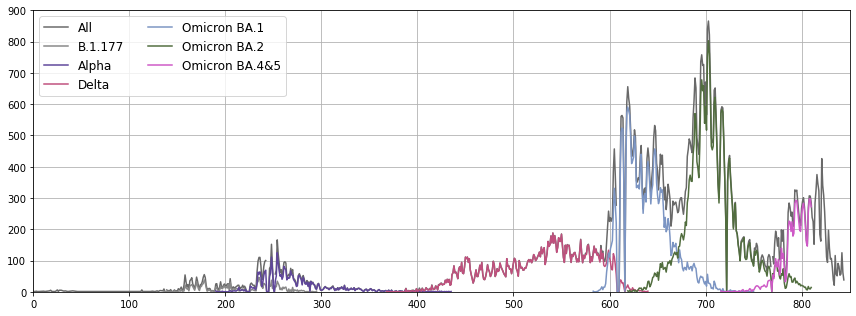

In [6]:
df_counts = LineageCounts(df_data, dict_lineages, t_ranges)

plt.figure(figsize=(12,4.5))

x_counts = df_counts.index
y_counts = df_counts.iloc[:,0].T.values.reshape(-1)
plt.plot(x_counts, y_counts, label='All', 
         c='dimgrey')

for i, column in enumerate(df_counts.columns[1:]):
    Z = df_counts[column]
    x_z = Z.index
    y_z = Z.T.values.reshape(-1)
    plt.plot(x_z, y_z, label=column, 
             c=maincols[i])

plt.legend(fontsize=12, ncol=2)
plt.ylim(0, 900); plt.xlim(0, 850)
plt.grid()
plt.tight_layout()

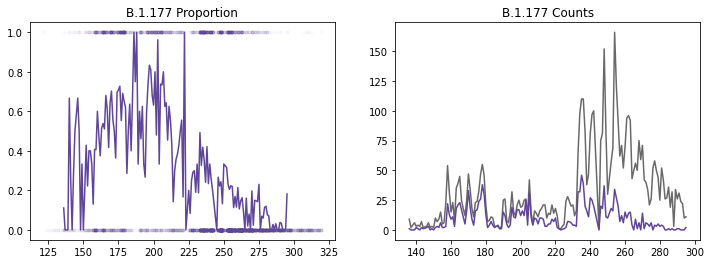

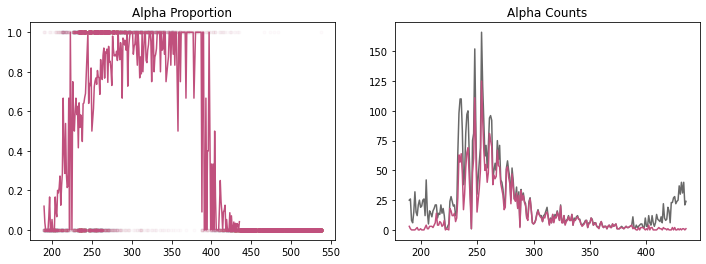

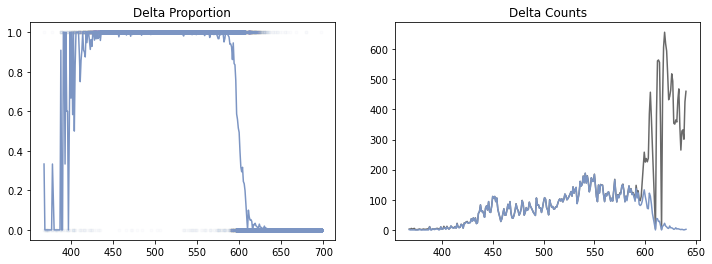

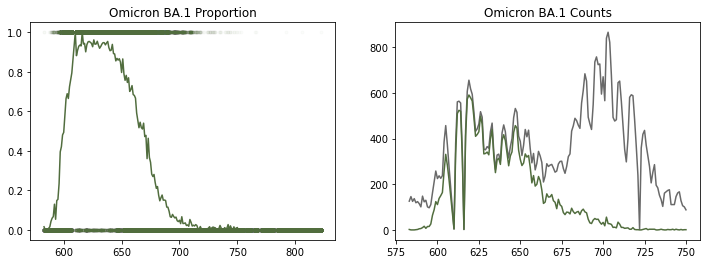

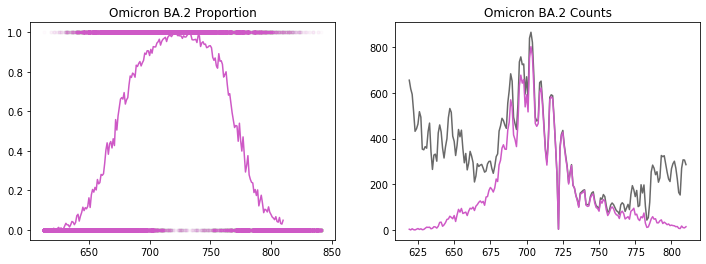

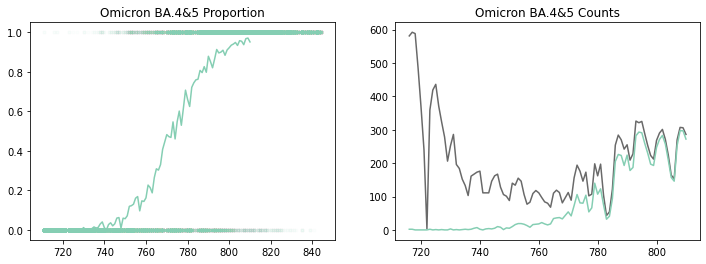

In [7]:
df_probabilities = LineageProbabilities(df_data, dict_lineages, t_ranges)
occurences = LineageOccurences(df_data, dict_lineages)
    
for i, lineage in enumerate(df_counts.columns[1:]):
    
    columns = ['All', lineage]
    df = df_counts.loc[:, columns]
    df.dropna(inplace=True)
    
    x_probabilities = df_probabilities[f'P_{lineage}'].dropna().index
    y1_lineage, y2_lineage = df.T.values
    x_lineage = df.index
    p_lineage = df_probabilities[f'P_{lineage}'].dropna()
    x_data, y_data = occurences[lineage].T.values
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(x_data, y_data,marker='.', 
                alpha=0.02, c=maincols[i+1])
    plt.plot(x_probabilities, p_lineage, 
             c=maincols[i+1])
    plt.title(lineage + ' Proportion')
    
    plt.subplot(1,2,2)
    plt.plot(x_lineage, y1_lineage, 
             c='dimgrey')
    plt.plot(x_lineage, y2_lineage, 
             c=maincols[i+1])
    plt.title(lineage + ' Counts')

In [8]:
df_counts.sum()

All               96700.0
B.1.177            1458.0
Alpha              3477.0
Delta             17780.0
Omicron BA.1      24541.0
Omicron BA.2      32950.0
Omicron BA.4&5     7584.0
dtype: float64

In [9]:
data = GPFitting(occurences, df_counts)

Loaded data for B.1.177
Running Gaussian process classification.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for Alpha
Running Gaussian process classification.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for Delta
Too large for GPC (55521 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for Omicron BA.1
Too large for GPC (73569 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for Omicron BA.2
Too large for GPC (70020 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Loaded data for Omicron BA.4&5
Too large for GPC (26877 samples). Running Gaussian Process Regression.
Main fit done. Bootstrap progress:


  0%|          | 0/200 [00:00<?, ?it/s]

# Plot

In [10]:
hlscols = [colorsys.rgb_to_hls(*mc.to_rgb(c)) for c in maincols]
dotcols = [mc.to_hex(colorsys.hls_to_rgb(c[0], 0.67 * c[1], c[2])) for c in hlscols]
bootcols = [mc.to_hex(colorsys.hls_to_rgb(c[0], 0.5 * (c[1]+1), c[2])) for c in hlscols]

mks = ['^', 'o', 'x', 'd',
       's', 'v', '*',]

tmi = 125
tma = 810
m = len(dotcols)-1

lineages = df_counts.columns[1:]

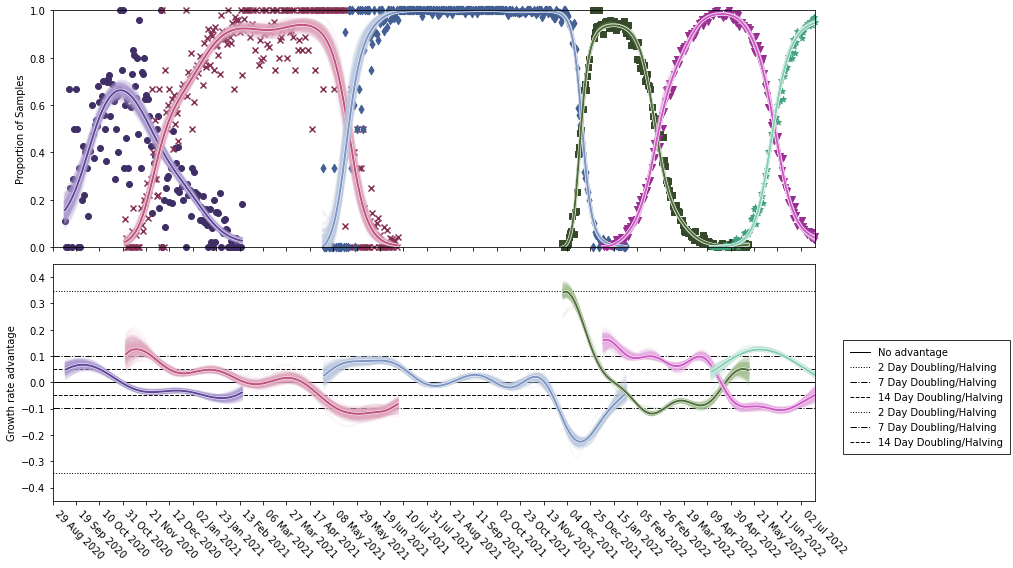

In [11]:
uu = np.arange(tmi, tma, 21)
dd = [(pd.Timestamp("2020-04-26") + timedelta(days=int(u))).strftime("%d %b %Y") for u in (uu)]

fig = plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
for i, lineage in enumerate(lineages):
    
    X0 = df_probabilities[f'P_{lineage}'].dropna().index
    p = df_probabilities[f'P_{lineage}'].dropna().values
    plt.scatter(X0, p, c=dotcols[i+1], marker=mks[i+1], clip_on=False)

    plt.plot([0,0], [0,0], c=bootcols[i+1], lw=1, alpha=1)

    nboot = data['Pi_boot'][lineage].shape[0]
    boots = data['Pi_boot'][lineage].columns
    for j in boots:
        pp = data['Pi_boot'][lineage].loc[:, j]
        X0 = data['Pi_boot'][lineage].index
        plt.plot(X0, pp, c=bootcols[i+1], lw=2, alpha=0.1)
    pp = data['Pi_store'][lineage].values.T
    X0 = data['Pi_store'][lineage].index
    plt.plot(X0,pp,c='w',lw=3)
    plt.plot(X0,pp,c=maincols[i+1],lw=2)
    
plt.ylabel('Proportion of Samples')
plt.xlim([tmi, tma])
plt.ylim([0,1])
plt.xticks(uu,[])

ax4 = plt.subplot(2,1,2)
for i, lineage in enumerate(lineages):
    
    X0 = data['r_boot'][lineage].index
    nboot = data['r_boot'][lineage].shape[0]
    boots = data['r_boot'][lineage].columns
    for j in boots:
        rr = data['r_boot'][lineage].loc[:,j]
        rr_len = len(rr)-1
        plt.plot(X0, rr, c=bootcols[i+1], lw=2, alpha=0.1)

    rr = data['r_store'][lineage].values.T
    X0 = data['r_store'][lineage].index
    plt.plot(X0, rr, c='w', lw=3)
    plt.plot(X0, rr, c=maincols[i+1], lw=2)

plt.plot(np.array([tmi, tma]), np.zeros(2), c='k', lw=1, ls='-', label='No advantage', zorder=0)
plt.plot(np.array([tmi, tma]), (np.log(2)/2)*np.ones(2), c='k', lw=1, ls=':', label='2 Day Doubling/Halving', zorder=0)
plt.plot(np.array([tmi, tma]), (np.log(2)/7)*np.ones(2), c='k', lw=1, ls='-.', label='7 Day Doubling/Halving', zorder=0)
plt.plot(np.array([tmi, tma]), (np.log(2)/14)*np.ones(2), c='k', lw=1, ls='--', label='14 Day Doubling/Halving', zorder=0)
plt.plot(np.array([tmi, tma]), -(np.log(2)/2)*np.ones(2), c='k', lw=1, ls=':', label='2 Day Doubling/Halving', zorder=0)
plt.plot(np.array([tmi, tma]), -(np.log(2)/7)*np.ones(2), c='k', lw=1, ls='-.', label='7 Day Doubling/Halving', zorder=0)
plt.plot(np.array([tmi, tma]), -(np.log(2)/14)*np.ones(2), c='k', lw=1, ls='--', label='14 Day Doubling/Halving', zorder=0)
    
plt.ylabel('Growth rate advantage')
plt.xlim([tmi, tma])
plt.ylim([-0.45,0.45])
plt.xticks(uu, dd ,rotation=-45, ha="left")
leg = fig.legend(loc='lower right', bbox_to_anchor=(1.175, 0.2))
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_boxstyle('Square')

plt.tight_layout()

## Save Text Files

In [12]:
output_dir = './output'

In [13]:
df_counts.to_csv(join(output_dir, 'Counts.csv'))
df_probabilities.to_csv(join(output_dir, 'Probabilities.csv'))
data['Pi_store'].to_csv(join(output_dir, 'Pi_store.csv'))
data['r_store'].to_csv(join(output_dir, 'r_store.csv'))
for lin in data['Pi_boot']:
    data['Pi_boot'][lin].to_csv(join(output_dir, lin + '_Pi_boot.csv'))
for lin in data['r_boot']:
    data['r_boot'][lin].to_csv(join(output_dir, lin + '_r_boot.csv'))